## Take a circuit, Transpile then Find cuts using Automatic Cut Finder

### Draw The Circuit

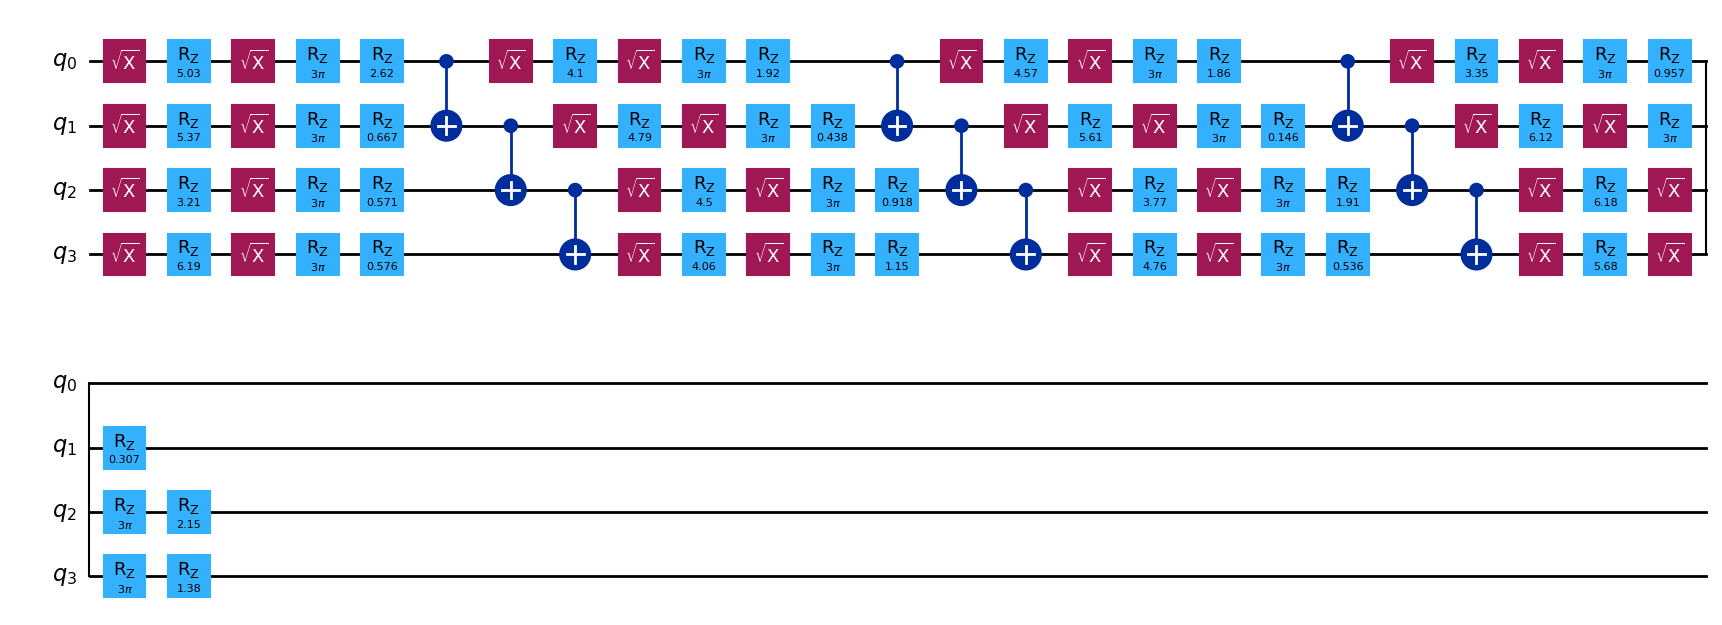

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


circuit = QuantumCircuit.from_qasm_file("/Users/debarthipal/Library/CloudStorage/OneDrive-IBM/Desktop/VS files/QASM_circuits_small/vqe_n4.qasm")
circuit=circuit.remove_final_measurements(inplace=False)
circuit.draw("mpl")

### Specify an Observable

In [3]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


### Choose a backend

In [4]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

### Synthesize the Circuit

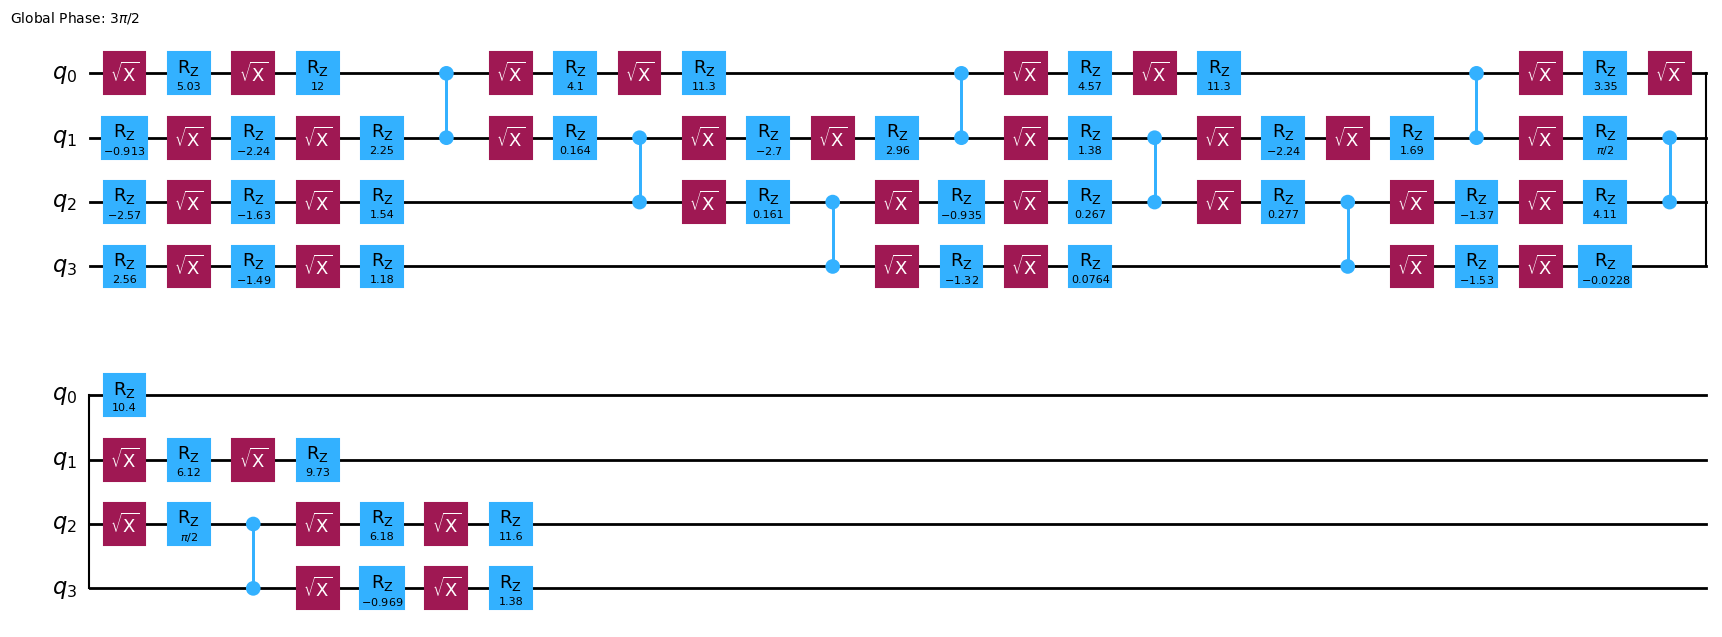

In [5]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

In [6]:
print(" The depth of the synthesized circuit is : ",synth_circuit.depth() )

 The depth of the synthesized circuit is :  32


### Giving the circuit to Automatic Cut Finder

Found solution using 3 cuts with a sampling overhead of 729.0.
Lowest cost solution found: True.
Gate Cut at circuit instruction index 21
Gate Cut at circuit instruction index 45
Gate Cut at circuit instruction index 68


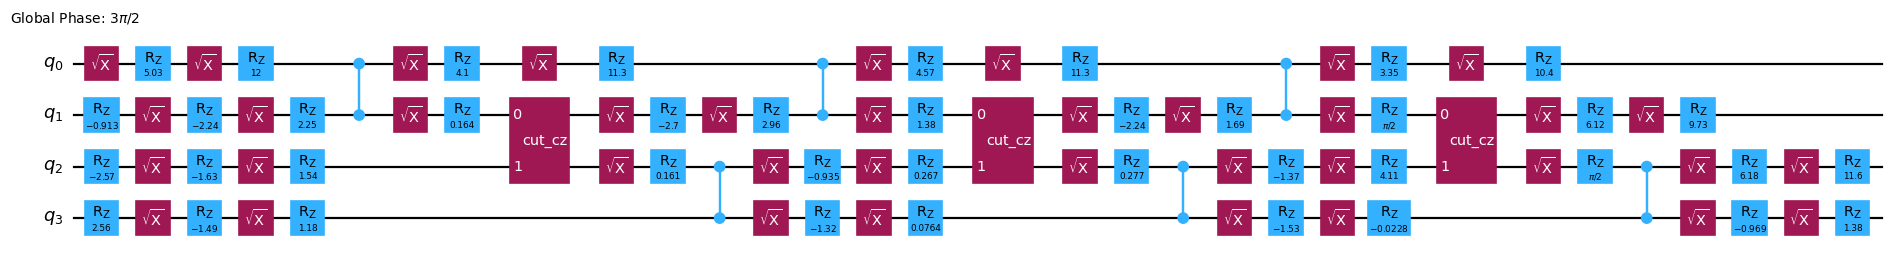

In [8]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_circuit.num_qubits//2))

cut_circuit, metadata = find_cuts(synth_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

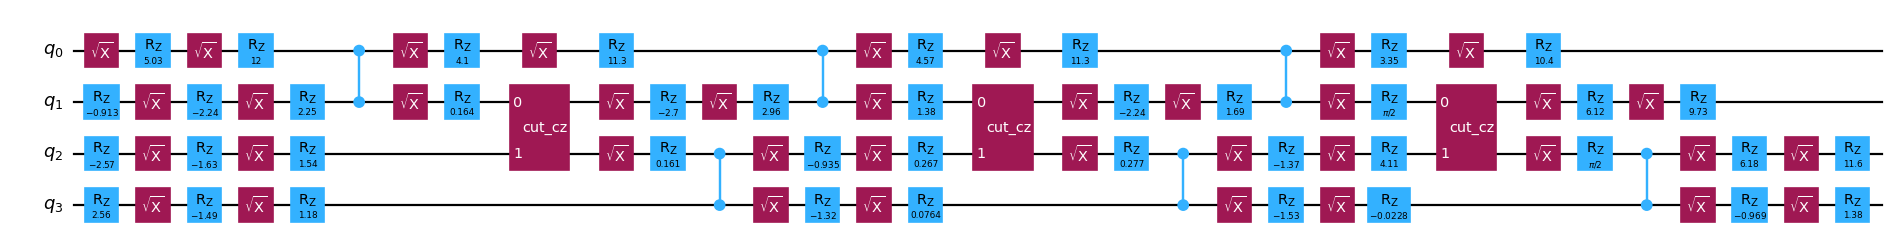

In [9]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [10]:
print(observables_expanded)

['ZIII', 'IZII', 'IIZI', 'IIIZ']


In [11]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 729.0


In [12]:
subobservables

{0: PauliList(['II', 'II', 'ZI', 'IZ']),
 1: PauliList(['ZI', 'IZ', 'II', 'II'])}

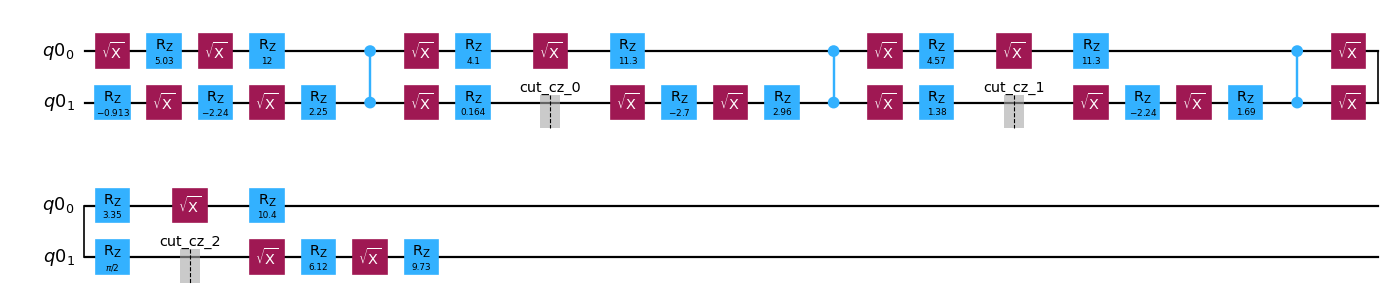

In [13]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

In [15]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
print(f"Total subexperiments are ",total_subexperiments)

Total subexperiments are  432


### Transpile the cut circuit to the backend

## Same Circuit: Synthesize, Do OBP, Find Cuts and then Transpile

### Draw the circuit

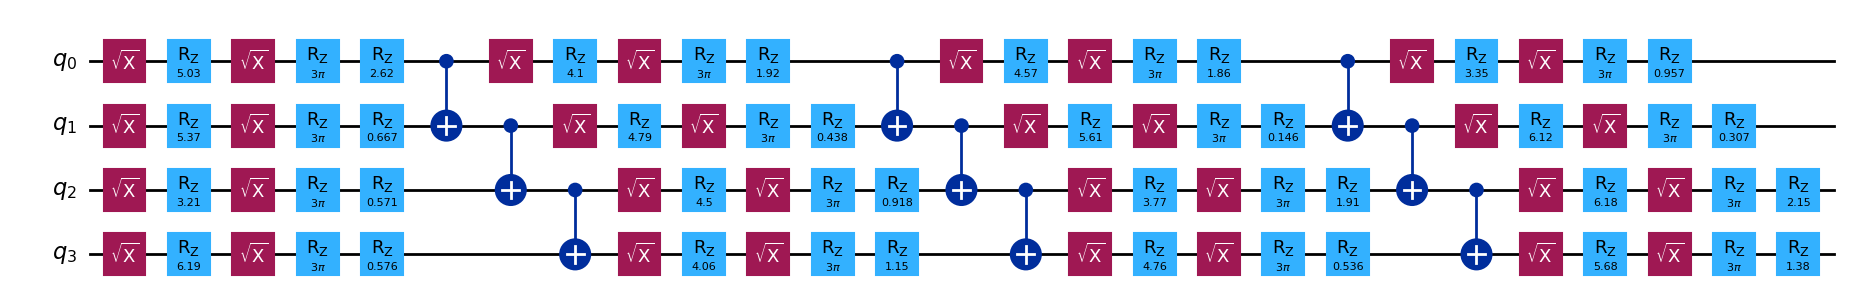

In [41]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


# we evolve for some time
circuit = QuantumCircuit.from_qasm_file("/Users/debarthipal/Library/CloudStorage/OneDrive-IBM/Desktop/VS files/QASM_circuits_small/vqe_n4.qasm")
circuit=circuit.remove_final_measurements(inplace=False)

circuit.draw("mpl", fold =-1)

### Specify an Observable

In [42]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ'],
              coeffs=[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j])


### Choose a Backend

In [43]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

### Synthesize the Circuit

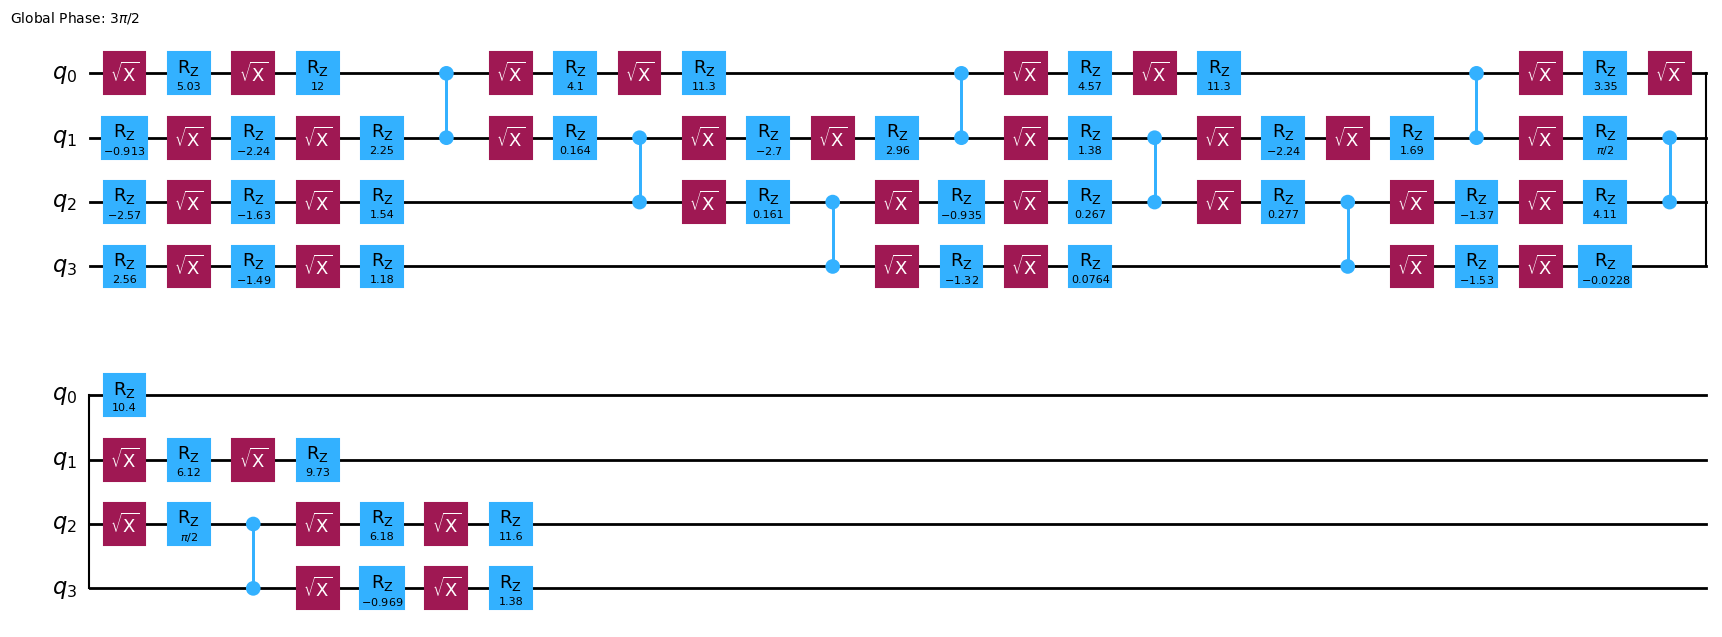

In [44]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")


### Define max non commuting groups and do slicing

In [45]:
# Define an operator budget list
operator_budget_list =[]
max_qwc_groups_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28]
for max_qwc_groups in max_qwc_groups_list:
    op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
    operator_budget_list.append(op_budget)
print(operator_budget_list)
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_circuit, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

[OperatorBudget(max_paulis=None, max_qwc_groups=1, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=2, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=3, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=4, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=5, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=6, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=7, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=8, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=9, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=10, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=None, max_qwc_groups=11, simplify=True, atol=None, rtol=None), OperatorBudget(max_paulis=Non

### Do Backpropagation

In [46]:
# Backpropagate without the truncation error budget
bp_circuit_list =[]
commuting_groups_list=[] # Stores the list of the non-commutig groups after backpropagation
backpropagated_observable_list =[]

for op_budget in operator_budget_list:
    backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
    )
    # Recombine the slices remaining after backpropagation
    bp_circuit = combine_slices(remaining_slices, include_barriers=False)
    num_non_commuting_groups=backpropagated_observable.group_commuting()
    if bp_circuit != None:
        print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
    #else:
    #    bp_circuit =QuantumCircuit(circuit.num_qubits)
        bp_circuit_list.append(bp_circuit)
    commuting_groups_list.append(len(num_non_commuting_groups))
    backpropagated_observable_list.append(backpropagated_observable)



Depth of the backpropagated circuit is:  30
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circuit is:  24
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  22
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  21
Depth of the backpropagated circuit is:  16
Depth of the backpropagated circuit is:  16
Depth of the backpropagated circuit is:  16
Depth of the backpropagated circ

In [47]:
bp_circuit_list

In [48]:
commuting_groups_list

[1,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

### Find cuts on the Backpropagated circuit

In [49]:
# Form the list of cut circuits
bp_cut_circuit_list =[]
bp_num_cuts_list =[]
bp_cut_sampling_overhead_list =[]
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

for bp_circuit in bp_circuit_list:
    # Specify the size of the QPUs available
    device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

    bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
    #print(metadata)
    print(
        f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
        f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
        #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
    )
    bp_cut_circuit_list.append(bp_cut_circuit)
    bp_num_cuts_list.append(len(bp_cut_metadata["cuts"]))
    bp_cut_sampling_overhead_list.append(bp_cut_metadata["sampling_overhead"])


print(bp_cut_circuit_list)
print(bp_num_cuts_list)
print(bp_cut_sampling_overhead_list)

Found solution using 3 cuts with a sampling overhead of 729.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead of 81.0.

Found solution using 2 cuts with a sampling overhead o

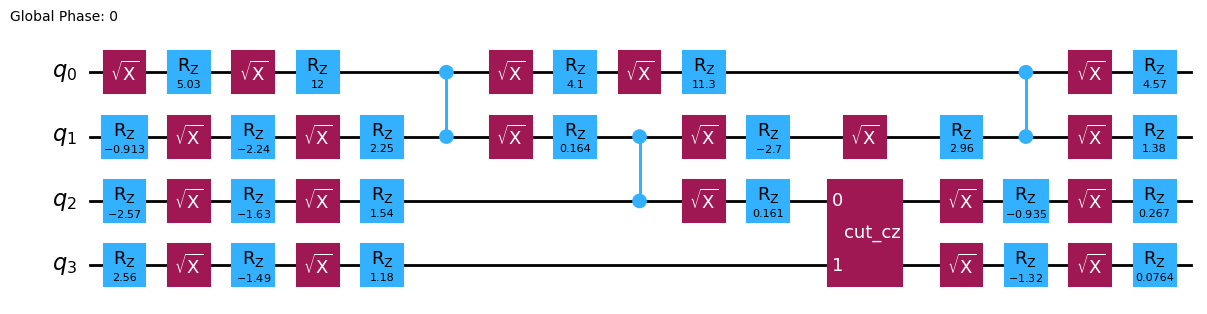

In [50]:
bp_cut_circuit_list[-5].draw("mpl")

In [51]:
from qiskit_addon_cutting import cut_wires, expand_observables
qc_w_ancilla_list=[]
observables_expanded_list=[]
for cut_ckt, bp_obs, bp_ckt in zip(bp_cut_circuit_list, backpropagated_observable_list, bp_circuit_list):
    qc_w_ancilla = cut_wires(cut_ckt)
    observables_expanded = expand_observables(bp_obs.paulis, bp_ckt, qc_w_ancilla)
    qc_w_ancilla_list.append(qc_w_ancilla)
    observables_expanded_list.append(observables_expanded)
    
    
    #qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)
print(qc_w_ancilla_list)
print(observables_expanded_list)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f02c6b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f2c6f60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f2c6cf0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11fecf6b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f0957c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11fe00fe0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f0075f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f094740>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11ef5e1b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f0c98e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f005850>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f2023c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f0ca6c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f0cb560>, <qiskit.circuit.qua

In [52]:
# qc_w_ancilla = cut_wires(bp_cut_circuit_list[-5])
# observables_expanded = expand_observables(backpropagated_observable_list[-5].paulis, bp_circuit_list[-5], qc_w_ancilla)

In [53]:
from qiskit_addon_cutting import partition_problem

subcircuits_list =[]
subobservables_list =[]
for qc_w_anc, obs_expan in zip(qc_w_ancilla_list, observables_expanded_list):

    partitioned_problem = partition_problem(
        circuit=qc_w_anc, observables=obs_expan
    )
    subcircuits = partitioned_problem.subcircuits
    subobservables = partitioned_problem.subobservables
    print(
        f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
    )
    subcircuits_list.append(subcircuits)
    subobservables_list.append(subobservables)
    #subcircuits[1].draw("mpl")
print(subcircuits_list)
print(subobservables_list)

Sampling overhead: 729.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 81.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
Sampling overhead: 9.0
[{0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11e6ecf80>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11fe0a810>}, {0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11f99f920>, 1: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11fc4a120>}, {0: <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11e39bb00>, 1: <qiskit.

In [54]:
# partitioned_problem = partition_problem(
#         circuit=qc_w_ancilla, observables=observables_expanded
#     )
# subcircuits = partitioned_problem.subcircuits
# subobservables = partitioned_problem.subobservables

In [55]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments_list =[]

for subckt, subobs in zip(subcircuits_list, subobservables_list):
    subexperiments, coefficients = generate_cutting_experiments(
        circuits=subckt, observables=subobs, num_samples=np.inf
    )
    #print(subexperiments)
    #break
    # print(
    #     f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
    # )
    # for i in list(subexperiments.keys()):
    #     subexperiments = len(subexperiments[i])
    # subexperiments_list.append(subexperiments)

    
    total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
    subexperiments_list.append(total_subexperiments)
    

print(subexperiments_list)

[432, 144, 144, 144, 216, 216, 216, 216, 216, 216, 288, 288, 288, 288, 288, 288, 288, 288, 288, 84, 84, 84, 84, 84, 84, 84]


In [ ]:
# subexperiments, coefficients = generate_cutting_experiments(
#         circuits=subcircuits, observables=subobservables, num_samples=np.inf
#     )
# total_subexperiments = sum(len(subexperiments[i]) for i in list(subexperiments.keys()))
# print(total_subexperiments)

84


In [35]:
subexperiments_list

[432,
 144,
 144,
 144,
 216,
 216,
 216,
 216,
 216,
 216,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 84,
 84,
 84,
 84,
 84,
 84]

In [ ]:
# from gradient_cc import find_min_qwc

# least_subexperiments, optimal_max_qwc_group = find_min_qwc(subexperiments_list, max_qwc_groups_list)
# print(f"The least number of subexperiments is ", least_subexperiments)
# print(f"The optimal value to take for max_qwc_group is ", optimal_max_qwc_group)

The least number of subexperiments is  144
The optimal value to take for max_qwc_group is  2


### Transpile the backpropagated circuit to the backend

In [37]:
"""backend=FakeTorino()
isa_subexperiments_list =[]
for subexperiments in subexperiments_list:
    # Transpile the subexperiments to ISA circuits
    pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)
    isa_subexperiments = {
        label: pass_manager.run(partition_subexpts)
        for label, partition_subexpts in subexperiments.items()
    }
    isa_subexperiments_list.append(isa_subexperiments)
    print(isa_subexperiments_list)"""

'backend=FakeTorino()\nisa_subexperiments_list =[]\nfor subexperiments in subexperiments_list:\n    # Transpile the subexperiments to ISA circuits\n    pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)\n    isa_subexperiments = {\n        label: pass_manager.run(partition_subexpts)\n        for label, partition_subexpts in subexperiments.items()\n    }\n    isa_subexperiments_list.append(isa_subexperiments)\n    print(isa_subexperiments_list)'

In [38]:
"""from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    job0 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[0].items()
    }

    job1 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[1].items()
    }

    job2 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[2].items()
    }

    job3 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[3].items()
    }

    job4 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[4].items()
    }

    job5 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[5].items()
    }

    job6 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[6].items()
    }

    job7 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[7].items()
    }

    job8 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[8].items()
    }

    job9 = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments_list[9].items()
    }"""

"from qiskit_ibm_runtime import SamplerV2, Batch\n\n# Submit each partition's subexperiments to the Qiskit Runtime Sampler\n# primitive, in a single batch so that the jobs will run back-to-back.\nwith Batch(backend=backend) as batch:\n    sampler = SamplerV2(mode=batch)\n    job0 = {\n        label: sampler.run(subsystem_subexpts, shots=2**12)\n        for label, subsystem_subexpts in isa_subexperiments_list[0].items()\n    }\n\n    job1 = {\n        label: sampler.run(subsystem_subexpts, shots=2**12)\n        for label, subsystem_subexpts in isa_subexperiments_list[1].items()\n    }\n\n    job2 = {\n        label: sampler.run(subsystem_subexpts, shots=2**12)\n        for label, subsystem_subexpts in isa_subexperiments_list[2].items()\n    }\n\n    job3 = {\n        label: sampler.run(subsystem_subexpts, shots=2**12)\n        for label, subsystem_subexpts in isa_subexperiments_list[3].items()\n    }\n\n    job4 = {\n        label: sampler.run(subsystem_subexpts, shots=2**12)\n        f

In [39]:
"""# Retrieve results
results0 = {label: job.result() for label, job in job0.items()}
results1= {label: job.result() for label, job in job1.items()}
results2 = {label: job.result() for label, job in job2.items()}
results3 = {label: job.result() for label, job in job3.items()}
results4 = {label: job.result() for label, job in job4.items()}
results5 = {label: job.result() for label, job in job5.items()}
results6 = {label: job.result() for label, job in job6.items()}
results7 = {label: job.result() for label, job in job7.items()}
results8 = {label: job.result() for label, job in job8.items()}
results9 = {label: job.result() for label, job in job9.items()}"""

'# Retrieve results\nresults0 = {label: job.result() for label, job in job0.items()}\nresults1= {label: job.result() for label, job in job1.items()}\nresults2 = {label: job.result() for label, job in job2.items()}\nresults3 = {label: job.result() for label, job in job3.items()}\nresults4 = {label: job.result() for label, job in job4.items()}\nresults5 = {label: job.result() for label, job in job5.items()}\nresults6 = {label: job.result() for label, job in job6.items()}\nresults7 = {label: job.result() for label, job in job7.items()}\nresults8 = {label: job.result() for label, job in job8.items()}\nresults9 = {label: job.result() for label, job in job9.items()}'

In [40]:
"""
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)
"""

'\nfrom qiskit_addon_cutting import reconstruct_expectation_values\n\n# Get expectation values for each observable term\nreconstructed_expval_terms = reconstruct_expectation_values(\n    results,\n    coefficients,\n    subobservables,\n)\n\n# Reconstruct final expectation value\nreconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)\n'

In [41]:
"""
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)
"""

'\nfrom qiskit_aer.primitives import EstimatorV2\n\nestimator = EstimatorV2()\nexact_expval = estimator.run([(qc, observable)]).result()[0].data.evs\nprint(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")\nprint(f"Exact expectation value: {np.round(exact_expval, 8)}")\nprint(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")\nprint(\n    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"\n)\n'

## Scratch Pad

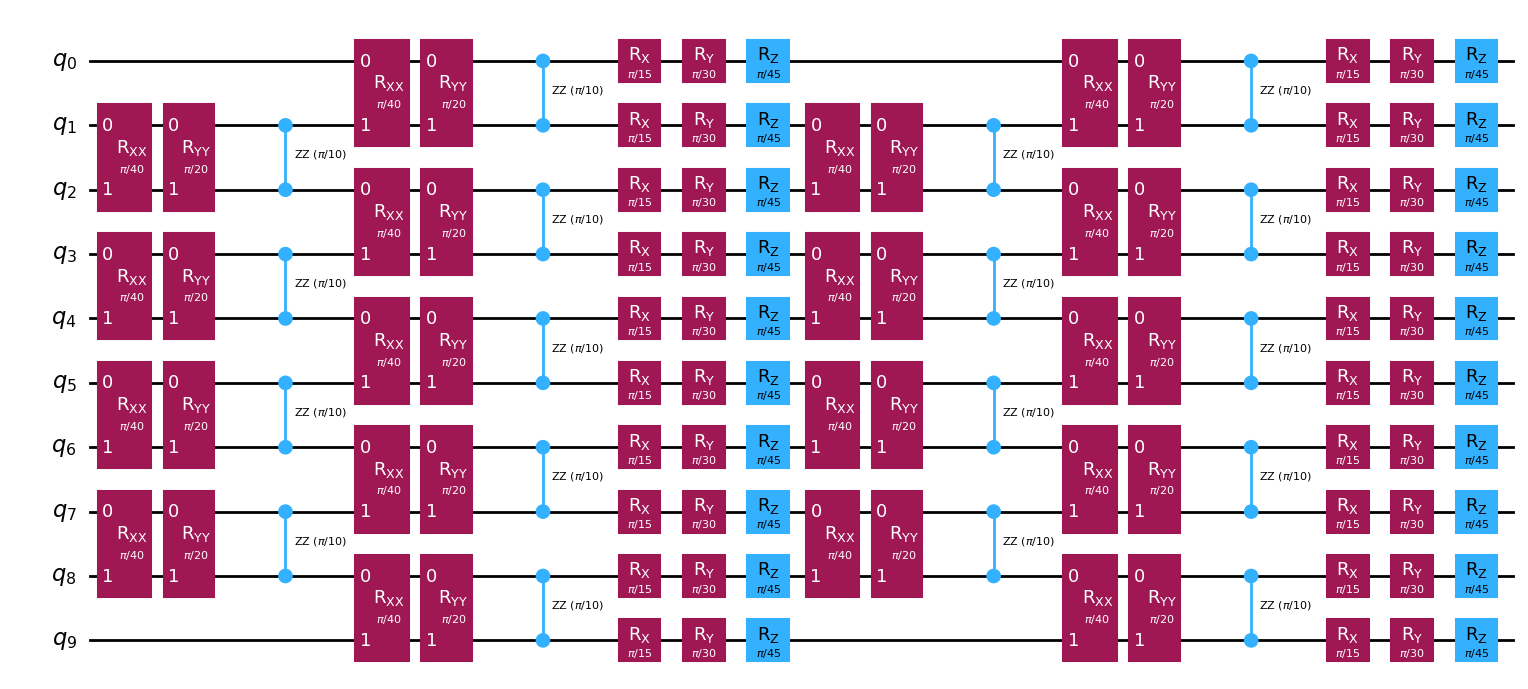

In [255]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)


circuit.draw("mpl")

In [256]:
# Specify a single-qubit observable
observable = SparsePauliOp('ZIIIIIIIII')
print(observable)

SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])


In [257]:
backend=FakeTorino()

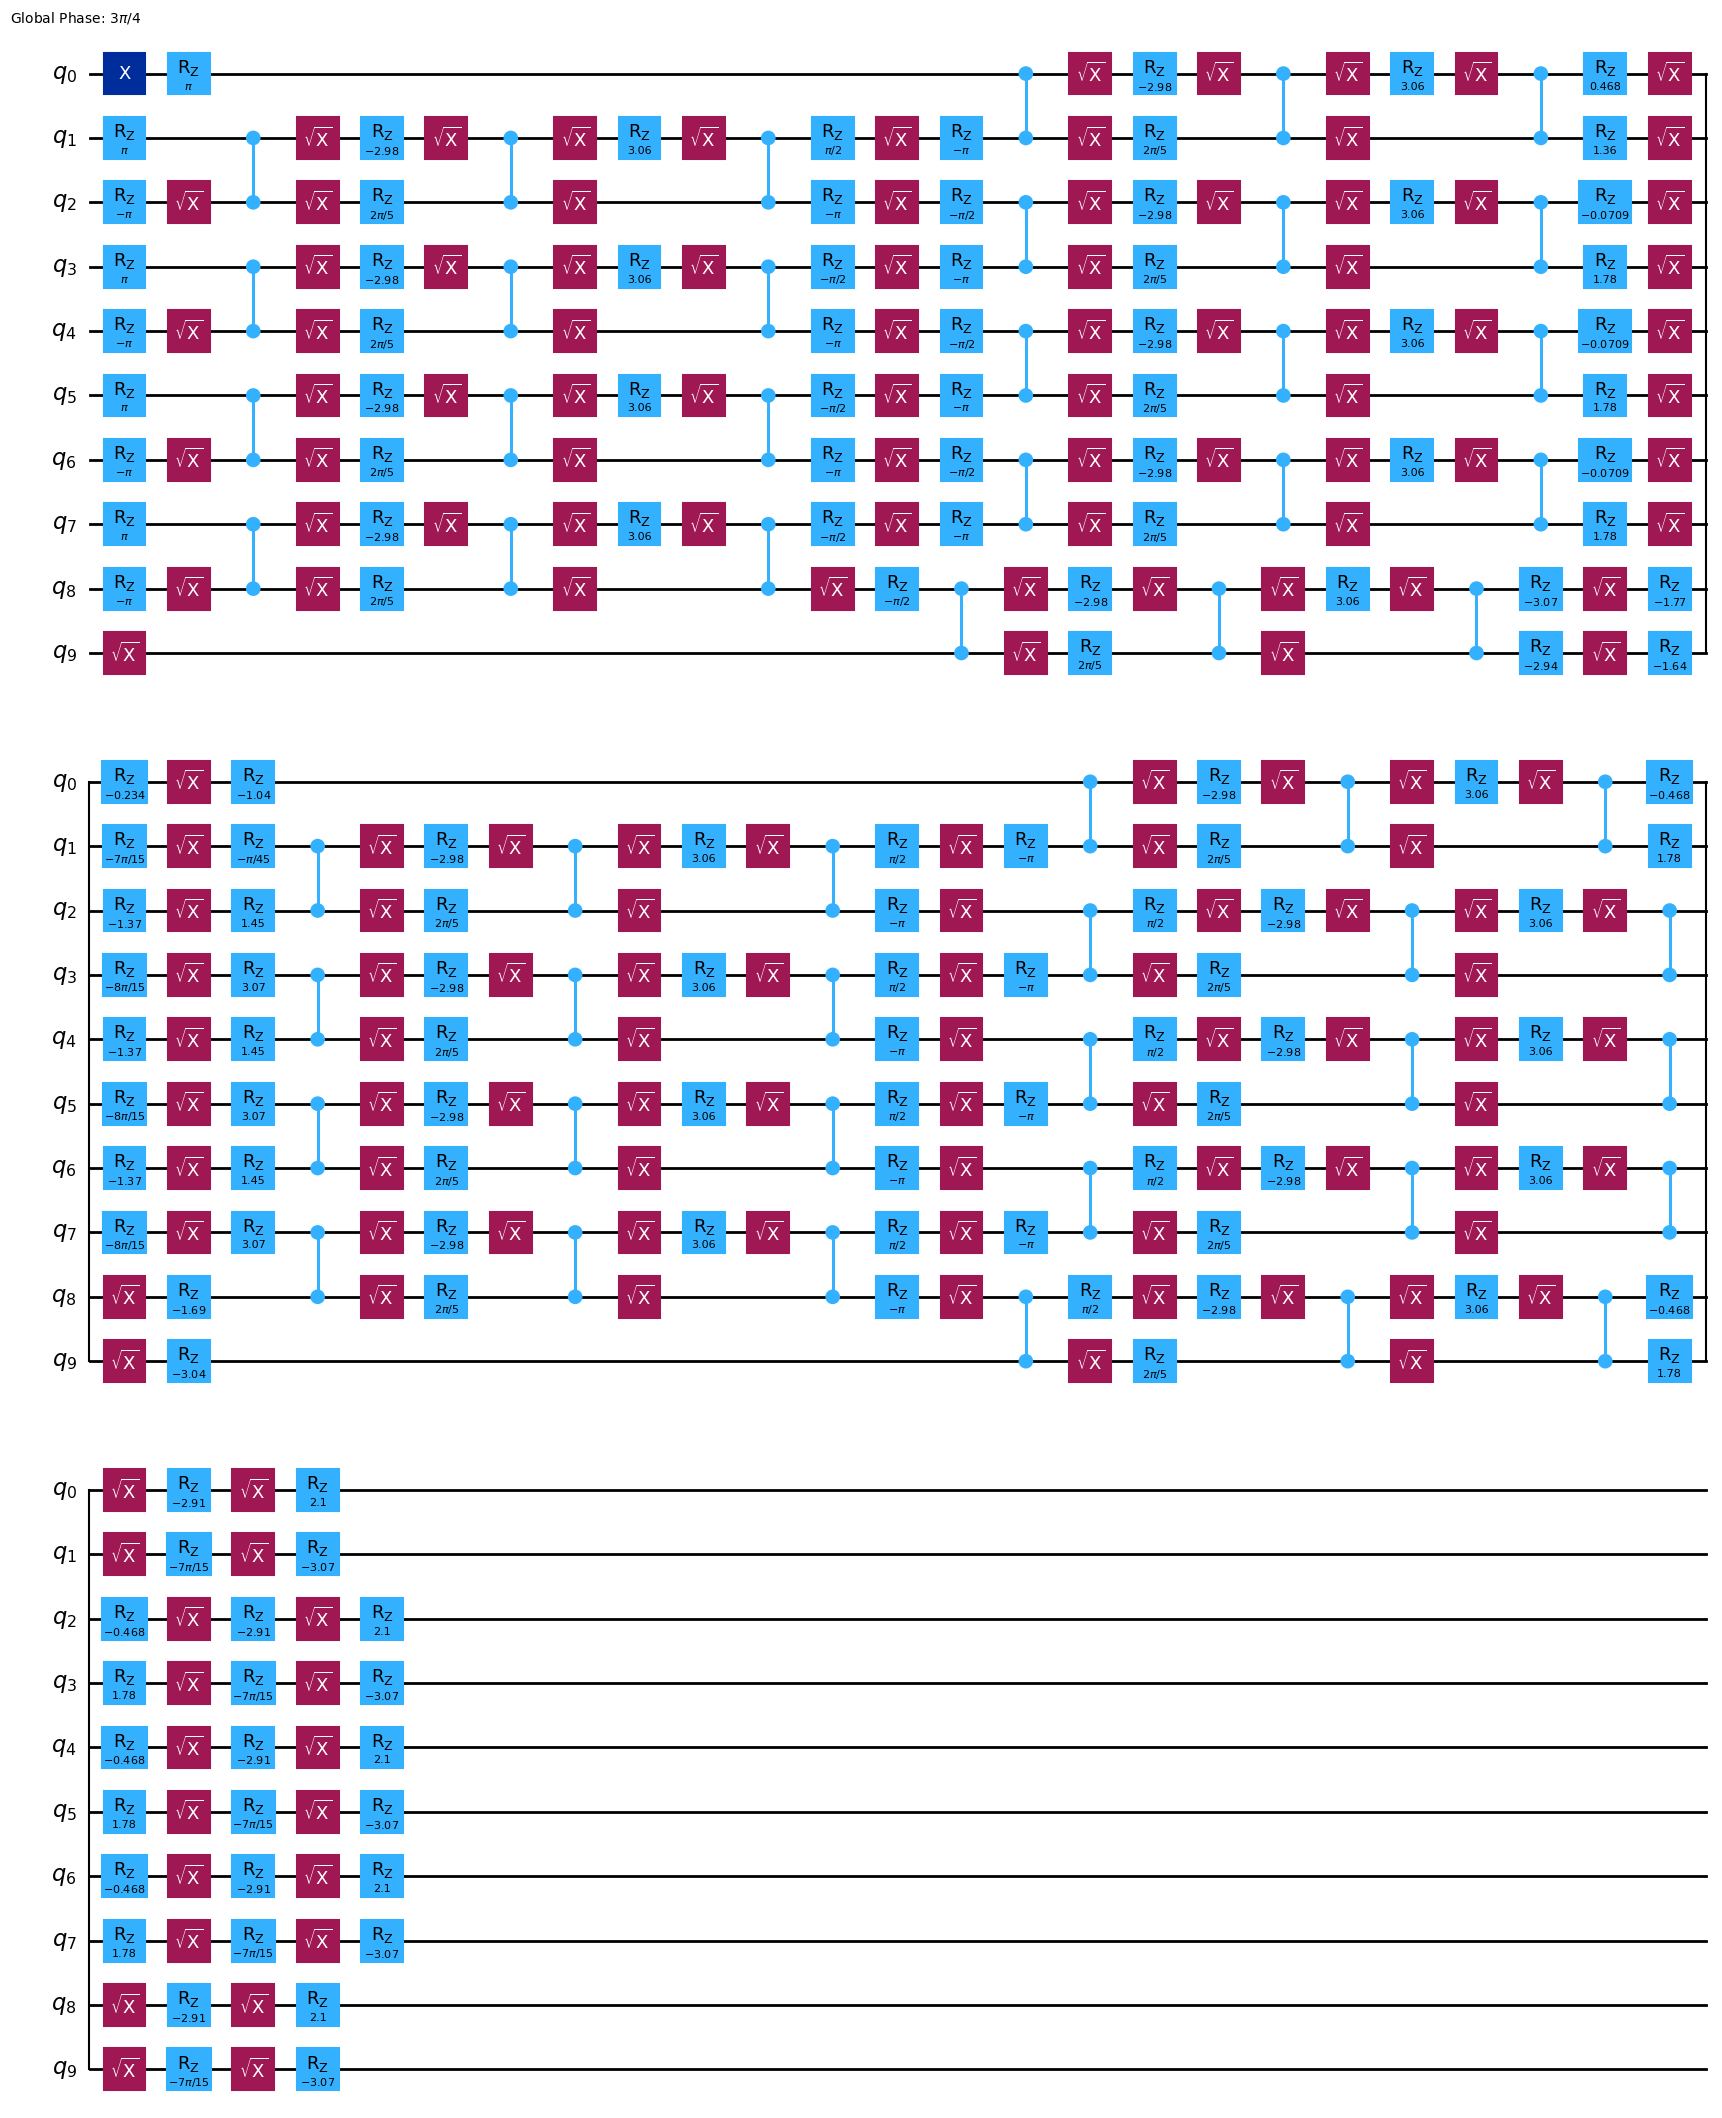

In [258]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

Found solution using 4 cuts with a sampling overhead of 11664.0.
Lowest cost solution found: True.
Gate Cut at circuit instruction index 145
Gate Cut at circuit instruction index 151
Gate Cut at circuit instruction index 156
Wire Cut at circuit instruction index 260


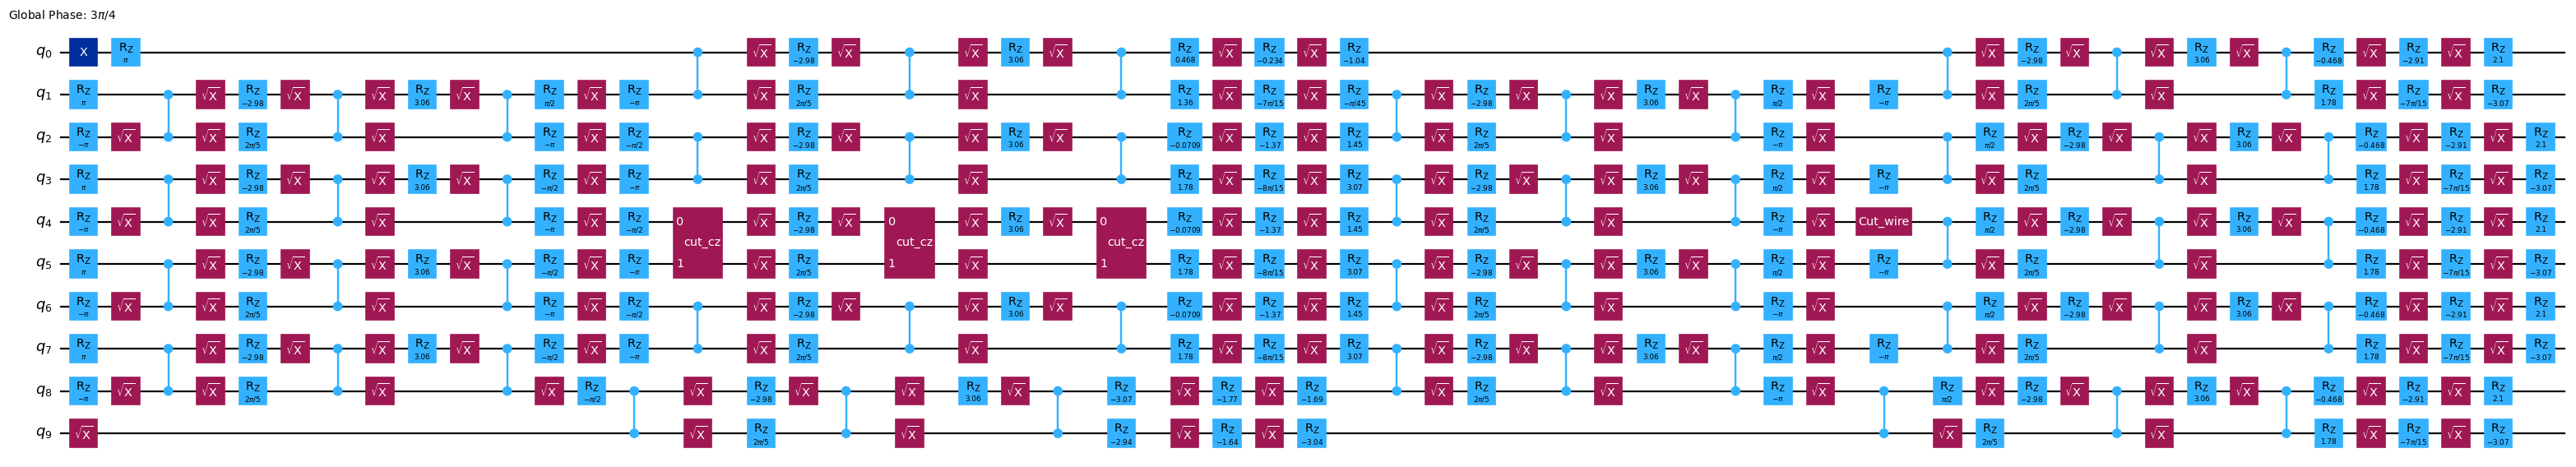

In [259]:
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(synth_circuit.num_qubits/2)+1)

cut_circuit, metadata = find_cuts(synth_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

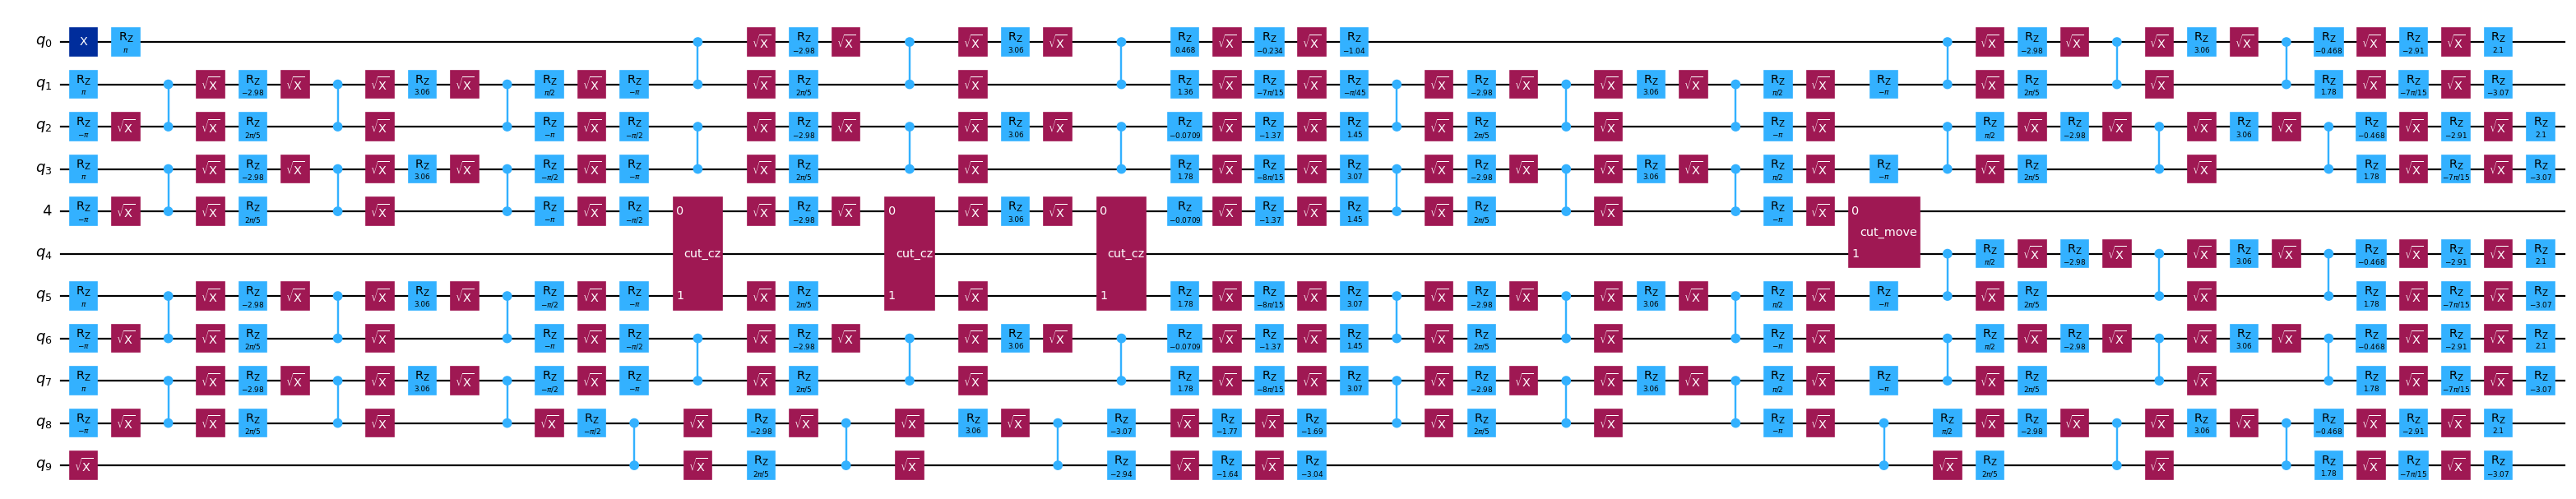

In [260]:
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, synth_circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [261]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

#subcircuits[1].draw("mpl")

Sampling overhead: 11664.0


In [262]:
from qiskit_addon_cutting import generate_cutting_experiments
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

3456 total subexperiments to run on backend.


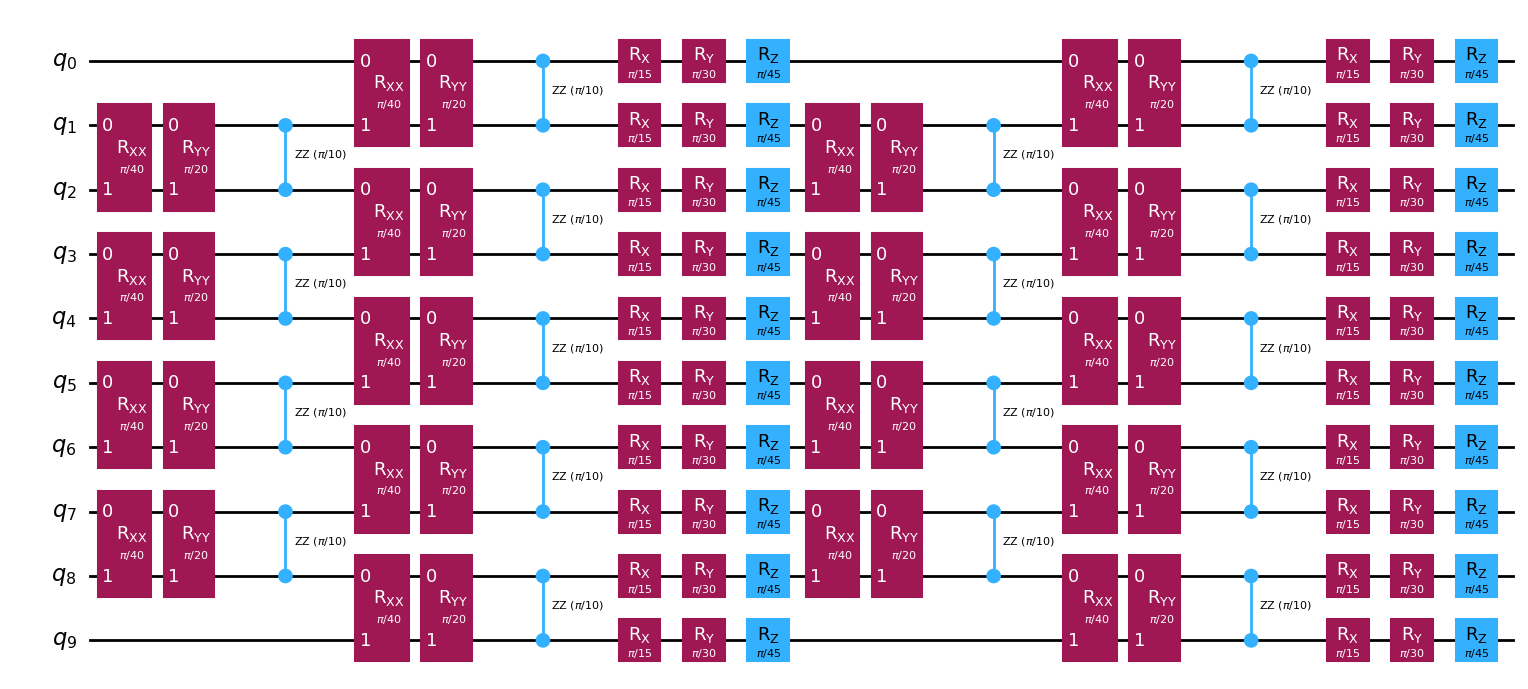

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=2), time=0.2
)


circuit.draw("mpl")

In [2]:
# Specify a single-qubit observable
observable = SparsePauliOp('ZIIIIIIIII')
print(observable)

SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])


In [3]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeTorino()

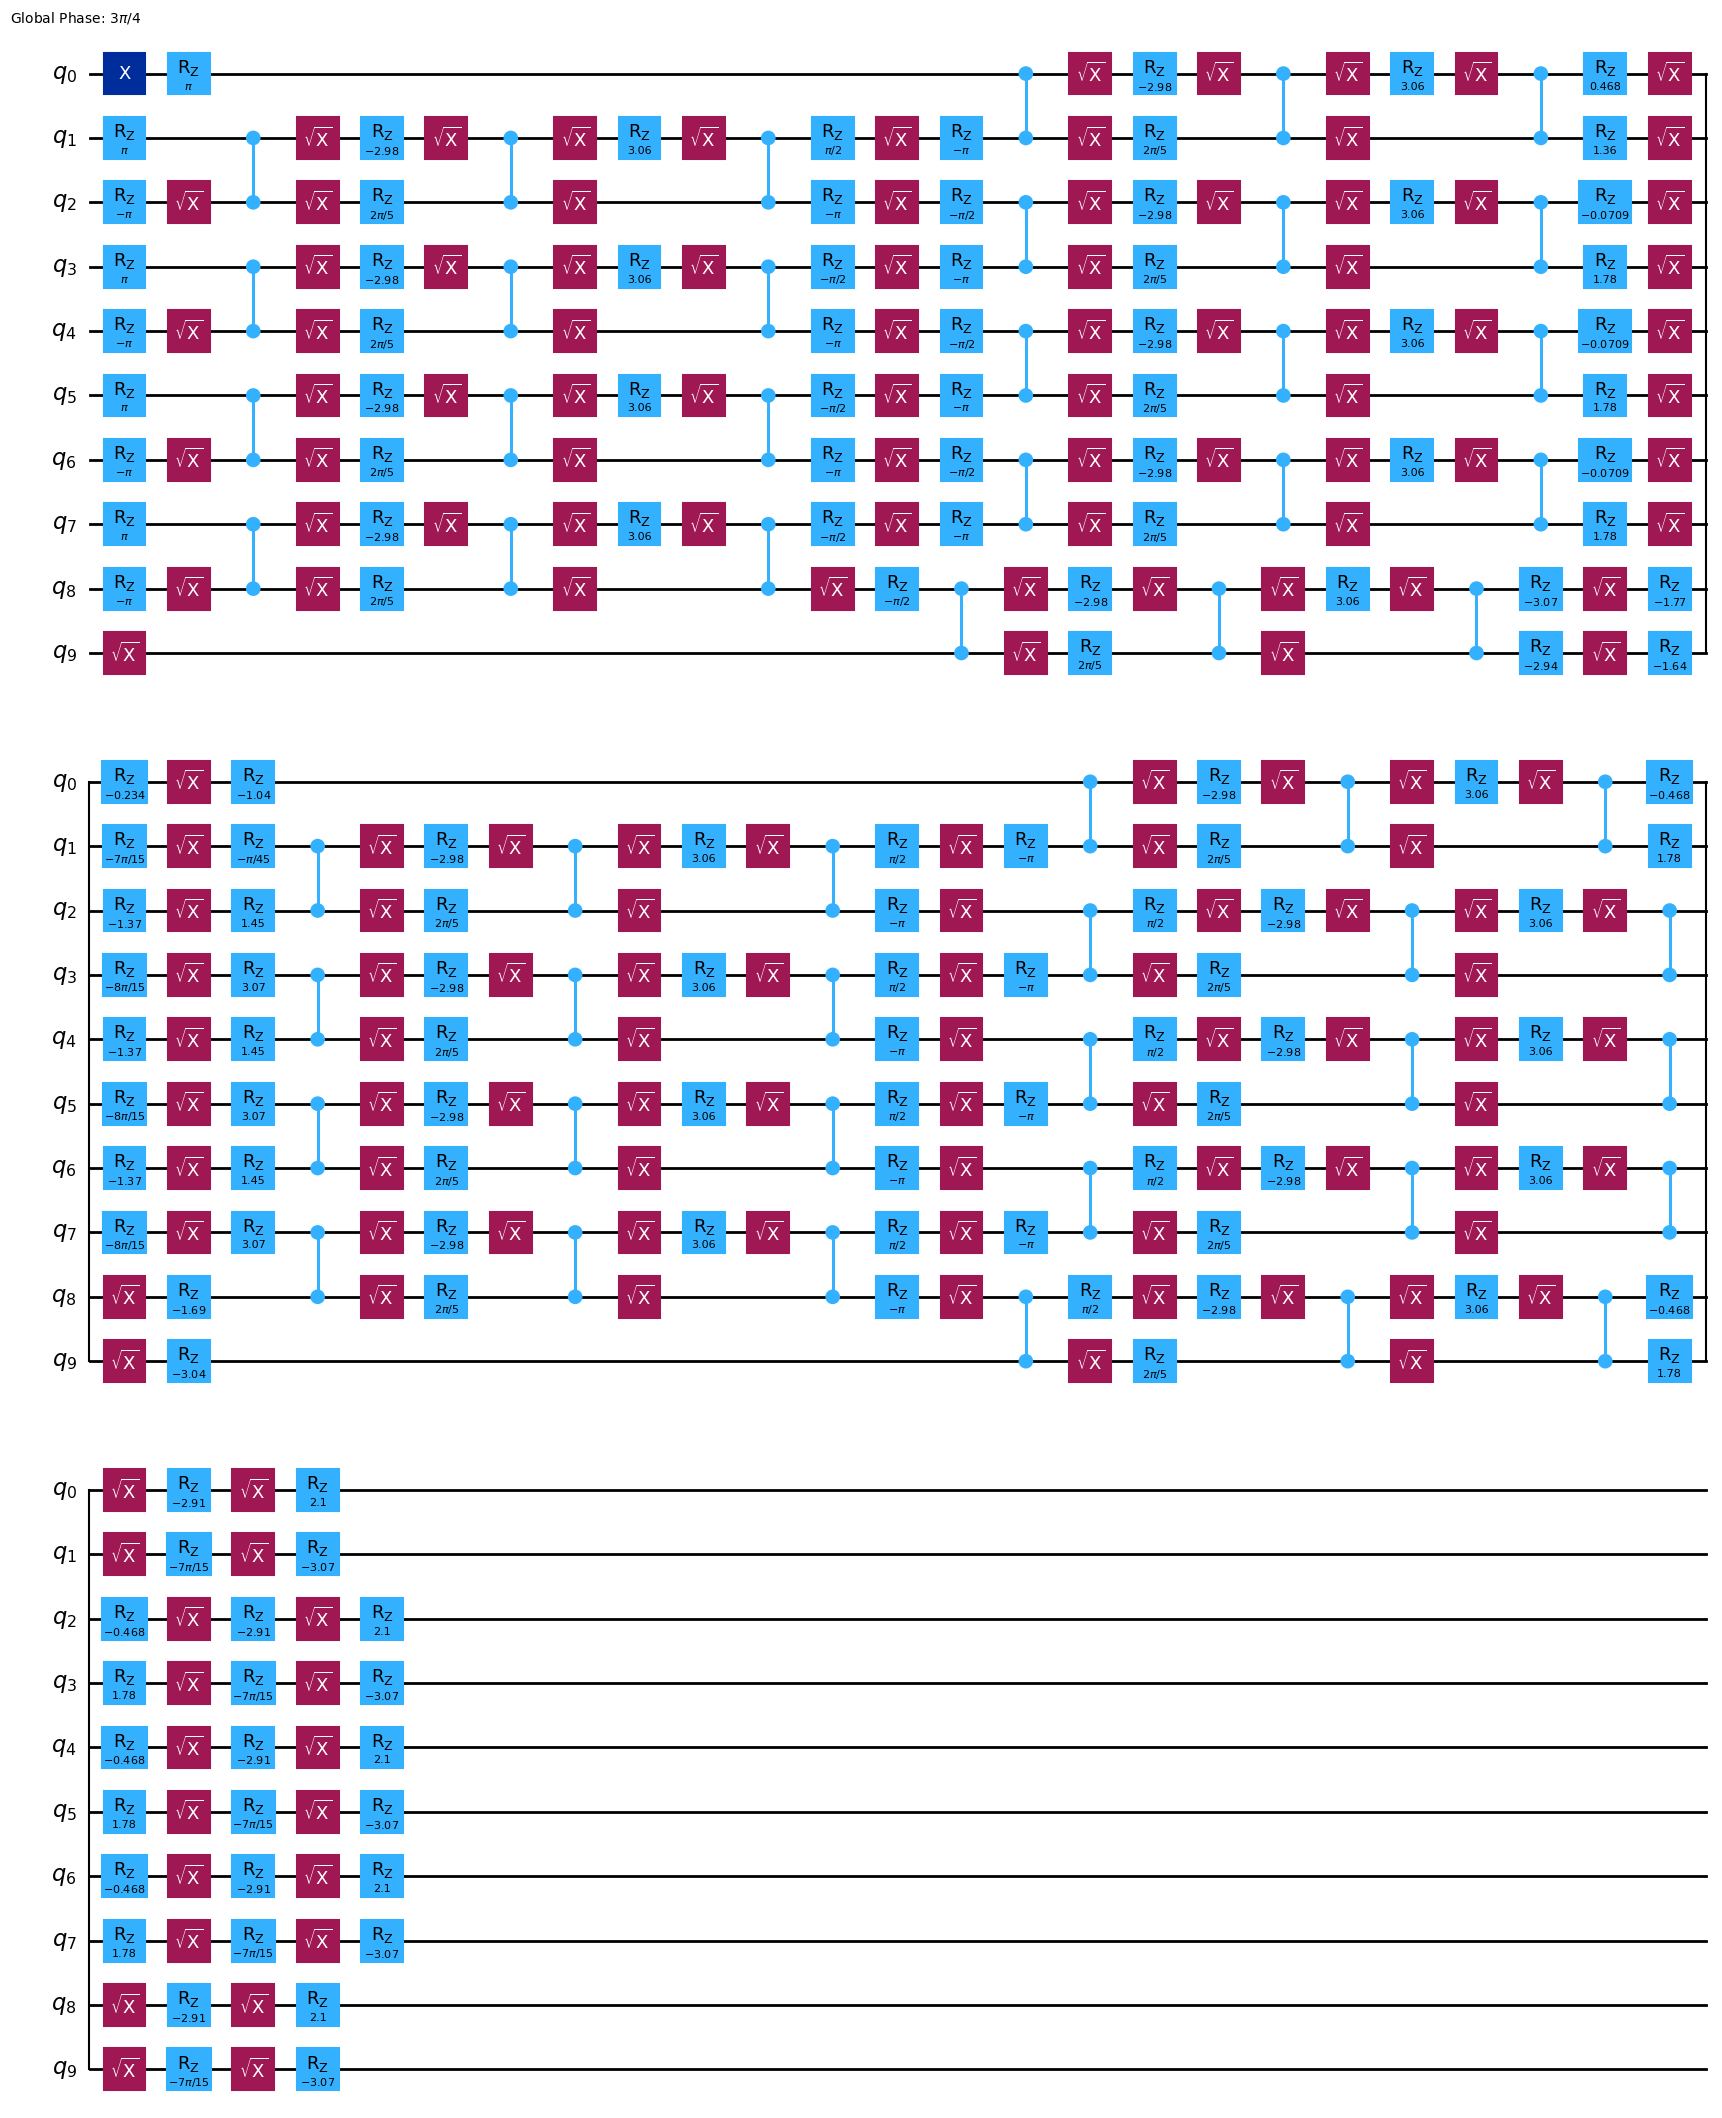

In [4]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)
synth_circuit = pm.run(circuit)
synth_circuit.draw("mpl")

In [ ]:
# Define an operator budget list
op_budget = OperatorBudget(max_qwc_groups=3)

In [5]:
# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(synth_circuit, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 55 slices.


In [ ]:
# Backpropagate without the truncation error budget

backpropagated_observable, remaining_slices, metadata = backpropagate(
observable,
synthesized_slices,
operator_budget=op_budget
)
# Recombine the slices remaining after backpropagation
bp_circuit = combine_slices(remaining_slices, include_barriers=False)
num_non_commuting_groups=backpropagated_observable.group_commuting()
print(f"Depth of the backpropagated circuit is: ", bp_circuit.depth())
print(f"The non commuting groups are: ",num_non_commuting_groups)
print(f"The number of non commuting groups is: ", len(num_non_commuting_groups))


AttributeError: 'NoneType' object has no attribute 'depth'

Found solution using 3 cuts with a sampling overhead of 2304.0.

Wire Cut at circuit instruction index 126
Wire Cut at circuit instruction index 207
Gate Cut at circuit instruction index 223


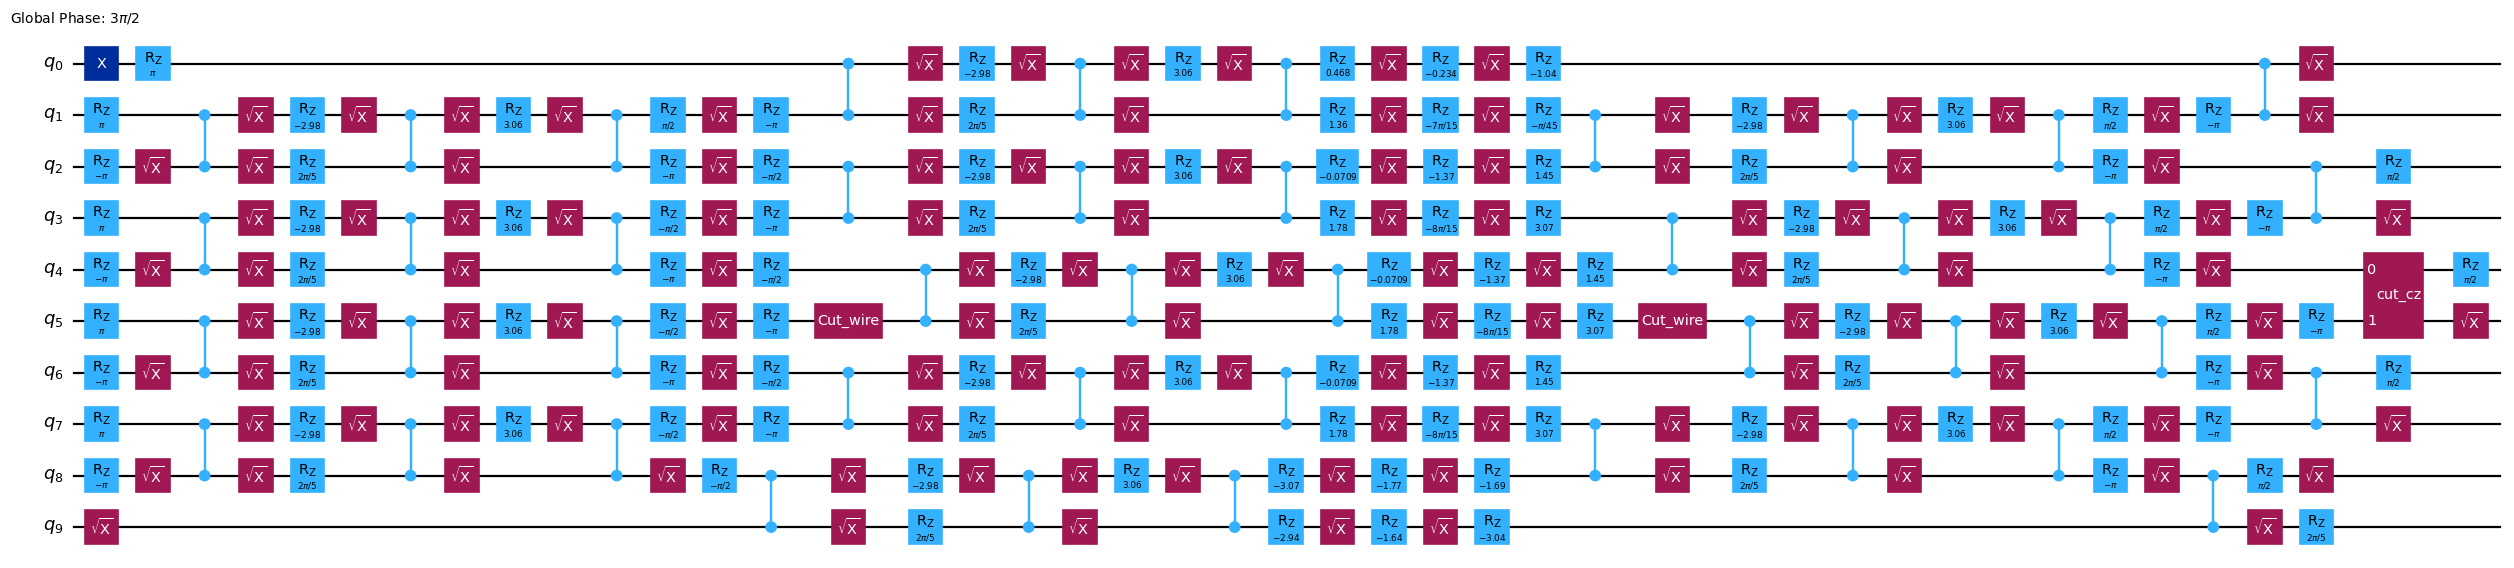

In [272]:
# Form the list of cut circuits
from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)


# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=(bp_circuit.num_qubits/2)+1)

bp_cut_circuit, bp_cut_metadata = find_cuts(bp_circuit, optimization_settings, device_constraints)
#print(metadata)
print(
    f'Found solution using {len(bp_cut_metadata["cuts"])} cuts with a sampling '
    f'overhead of {bp_cut_metadata["sampling_overhead"]}.\n'
    #f'Lowest cost solution found: {bp_metadata["minimum_reached"]}.'
)
for cut in bp_cut_metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
bp_cut_circuit.draw("mpl", scale=0.8, fold=-1)

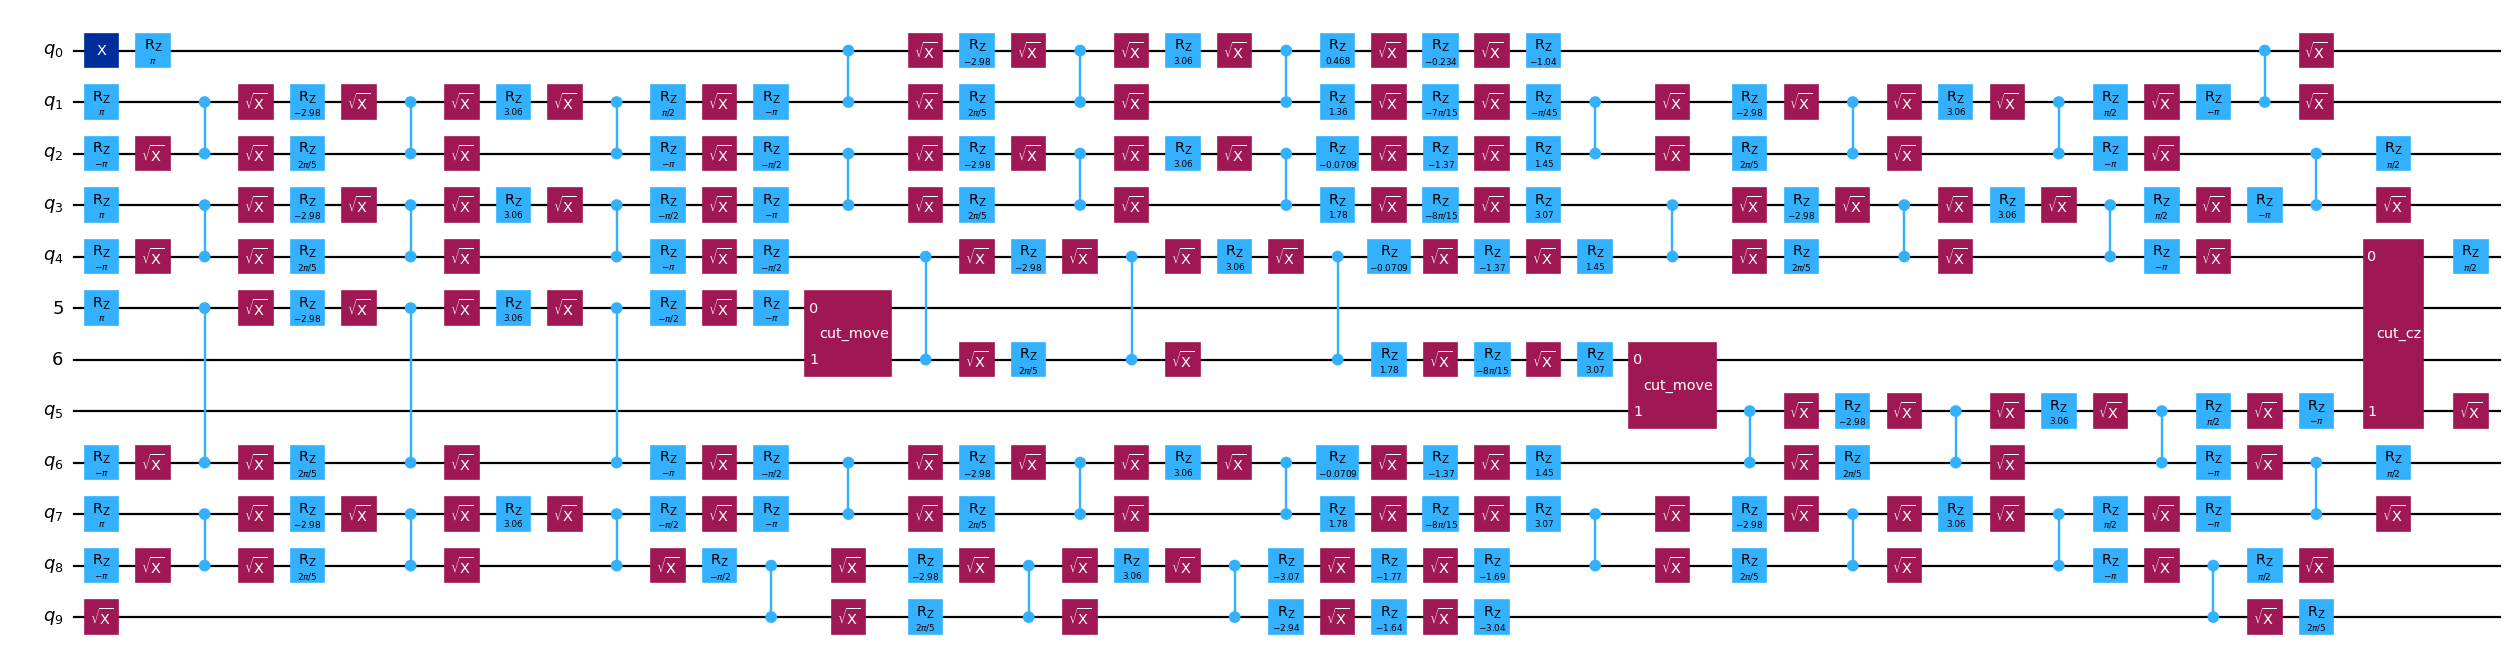

In [273]:
from qiskit_addon_cutting import cut_wires, expand_observables


qc_w_ancilla = cut_wires(bp_cut_circuit)
observables_expanded = expand_observables(backpropagated_observable.paulis, bp_circuit, qc_w_ancilla)
qc_w_ancilla_list.append(qc_w_ancilla)
observables_expanded_list.append(observables_expanded)
    
    
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)


Sampling overhead: 2304.0


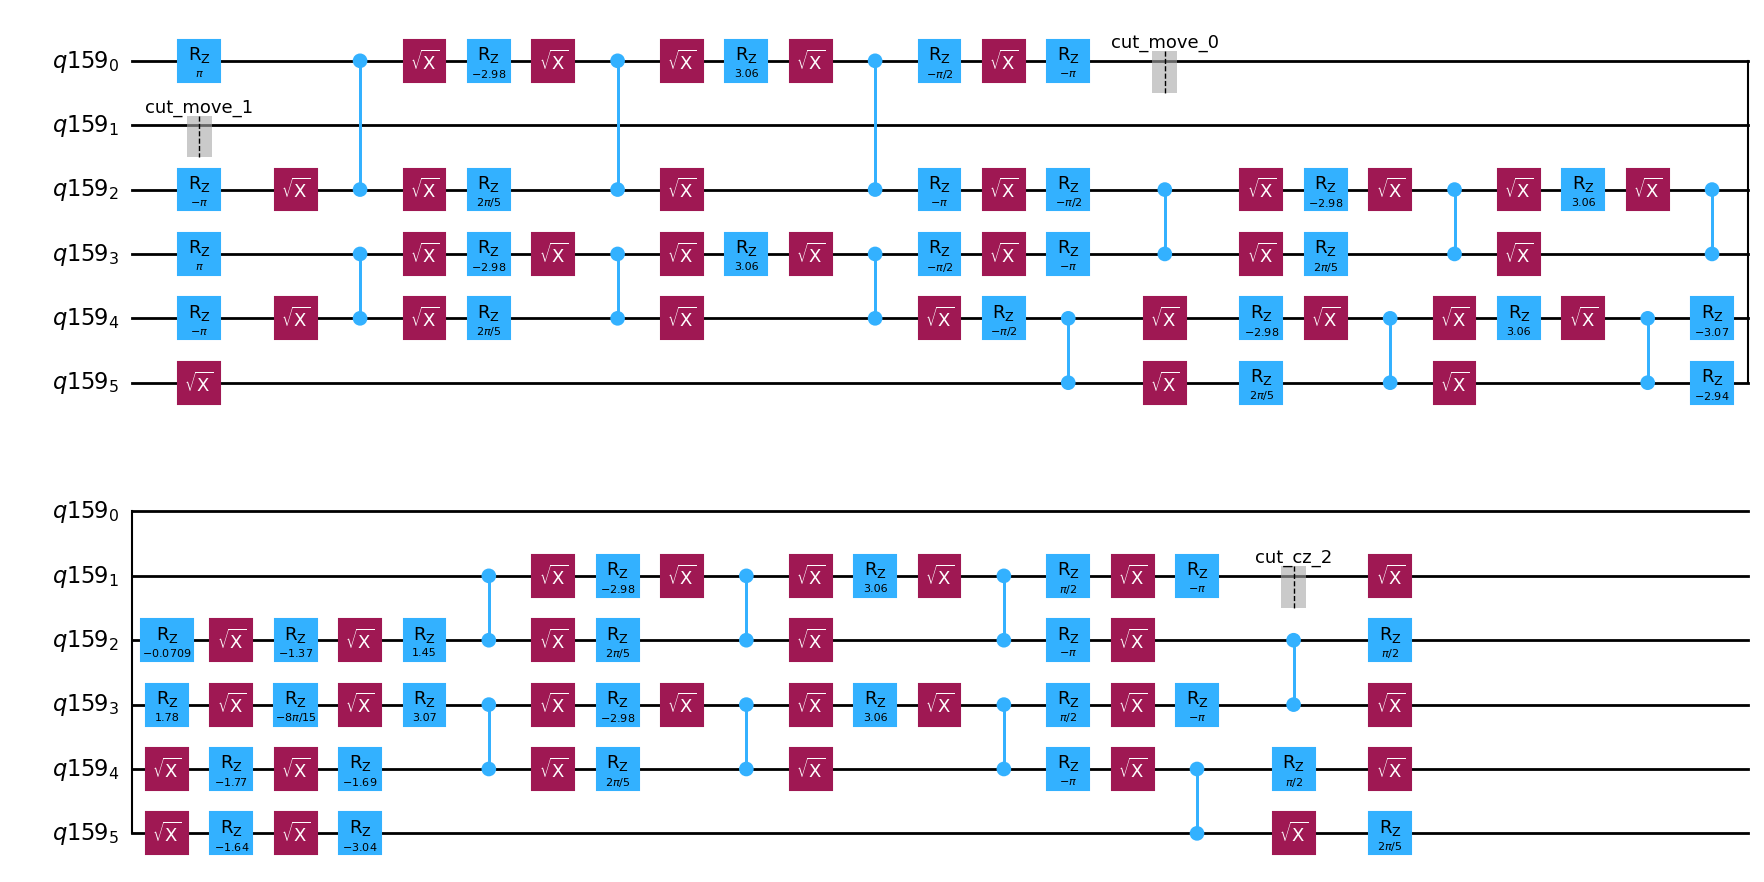

In [274]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)
subcircuits[1].draw("mpl")

In [275]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

2688 total subexperiments to run on backend.
